# Isolation Forest

In [10]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings(action="ignore")
path = './data/'
# Label for default in 30 days
all_signals_hourly_path_30 = 'all_signals_hourly_processed_30.csv'
# Label for default in 60 days
all_signals_hourly_path_60 = 'all_signals_hourly_processed.csv'

In [11]:
# Manual Split
def split_train_test(df, train_size=0.8):
    time_span = pd.unique(df.sort_values(by='Timestamp')['Timestamp'])
    st = time_span[int(len(time_span) * train_size)]
    train_df = df[df['Timestamp'] <= st].reset_index(drop = True)
    test_df = df[df['Timestamp'] > st].reset_index(drop = True)
    return train_df, test_df, st
def standard_scaler(X_train, X_test):
    scaler = StandardScaler()
    train_df = scaler.fit_transform(X_train)
    test_df = scaler.transform(X_test)
    return train_df, test_df
def apply_pca(X_train, X_test):
    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    # Fit and transform PCA on scaled training data
    X_train_pca = pca.fit_transform(X_train)
    # Transform the scaled testing data with the same PCA
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

def remove_highly_correlated_features(df, threshold=0.9):
    """
    Removes highly correlated features from a DataFrame based on a correlation threshold.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing features.
    - threshold (float): Correlation coefficient threshold. Features with correlations above this
                         value will be considered highly correlated and thus candidates for removal.

    Returns:
    - pd.DataFrame: DataFrame with reduced features.
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index/column names of features with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    print(f"Dropped columns: {to_drop}")
    return to_drop

def apply_isolation_forest(X_train, X_test, n_estimators=100, contamination='auto', random_state=42):
    """
    Apply Isolation Forest algorithm to detect anomalies in a DataFrame.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the features for anomaly detection.
    - n_estimators (int): The number of base estimators in the ensemble.
    - contamination (float or 'auto'): The proportion of outliers in the data set.
    - random_state (int): Controls the randomness of the estimator.

    Returns:
    - anomalies (np.array): Array where -1 indicates an anomaly and 1 indicates normal data.
    """
    # Initialize the Isolation Forest model
    iso_forest = IsolationForest(n_estimators=n_estimators,
                                 contamination=contamination,
                                 random_state=random_state)
    # Fit the model
    iso_forest.fit(X_train)
    # Predict anomalies (-1 for outliers and 1 for inliers)
    anomalies = iso_forest.predict(X_test)
    return anomalies
def evaluate_model(y_pred, y_true):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {precision}")
    recall = recall_score(y_true, y_pred)
    print(f"Recall: {recall}")
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1}")
    
def plot_correlation(df, title='Correlation Matrix', figsize=(10, 8), cmap='coolwarm'):
    """
    Plots a heatmap of the correlation matrix for a pandas DataFrame.

    Parameters:
    - df : pd.DataFrame
        The DataFrame whose correlation matrix will be calculated and plotted.
    - title : str, optional
        The title of the plot.
    - figsize : tuple, optional
        The size of the figure to be plotted (width, height).
    - cmap : str, optional
        The color map to use for the heatmap.

    Returns:
    - None
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Create a mask to hide the upper triangle of the heatmap (since it's symmetric)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1,
                annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .75})

    # Add the title and any necessary adjustments
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

    # Show the plot
    plt.show()

In [12]:
all_signals_hourly = pd.read_csv(path + all_signals_hourly_path_60)
all_signals_hourly['Timestamp'] = pd.to_datetime(all_signals_hourly['Timestamp'])
non_feature_columns = [
    'Turbine_ID', 'Timestamp',
    'Label_GENERATOR', 'Next_Default_Date_GENERATOR', 'Lead_Time_GENERATOR', 'Default_in_60_GENERATOR',
    'Label_HYDRAULIC_GROUP', 'Next_Default_Date_HYDRAULIC_GROUP', 'Lead_Time_HYDRAULIC_GROUP', 'Default_in_60_HYDRAULIC_GROUP',
    'Label_GENERATOR_BEARING', 'Next_Default_Date_GENERATOR_BEARING', 'Lead_Time_GENERATOR_BEARING', 'Default_in_60_GENERATOR_BEARING',
    'Label_TRANSFORMER', 'Next_Default_Date_TRANSFORMER', 'Lead_Time_TRANSFORMER', 'Default_in_60_TRANSFORMER',
    'Label_GEARBOX', 'Next_Default_Date_GEARBOX', 'Lead_Time_GEARBOX', 'Default_in_60_GEARBOX'
]
# Create a new DataFrame by dropping the specified columns
features = all_signals_hourly.drop(columns=non_feature_columns)

## Feature Selection

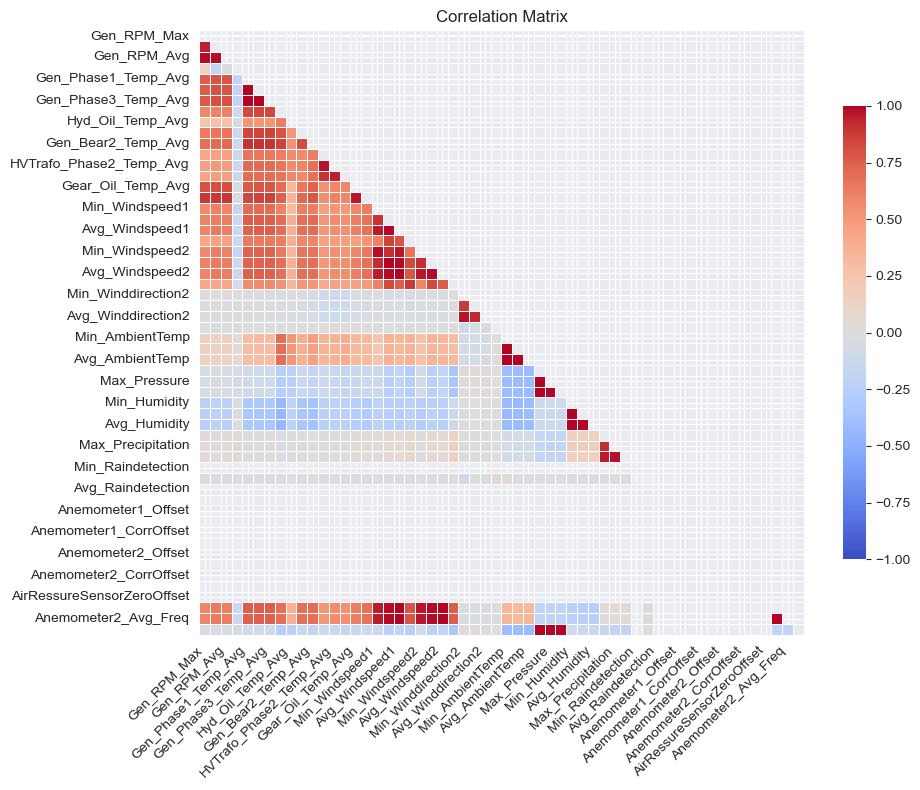

In [13]:
plot_correlation(features)

In [14]:
columns_due_to_high_corr = remove_highly_correlated_features(features, threshold=0.85)
columns_to_drop = ['Avg_Raindetection', 'Anemometer1_Freq',
                   'Anemometer1_Offset', 'Anemometer1_CorrGain', 'Anemometer1_CorrOffset',
                   'Anemometer2_Freq', 'Anemometer2_Offset', 'Anemometer2_CorrGain',
                   'Anemometer2_CorrOffset', 'DistanceAirPress',
                   'AirRessureSensorZeroOffset']
columns_to_drop.extend(columns_due_to_high_corr)
new_features = [f for f in features.columns if f not in columns_to_drop]
len(new_features)

Dropped columns: ['Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Gen_Bear2_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Max_Windspeed1', 'Avg_Windspeed1', 'Var_Windspeed1', 'Min_Windspeed2', 'Max_Windspeed2', 'Avg_Windspeed2', 'Var_Windspeed2', 'Max_Winddirection2', 'Avg_Winddirection2', 'Max_AmbientTemp', 'Avg_AmbientTemp', 'Max_Pressure', 'Avg_Pressure', 'Max_Humidity', 'Avg_Humidity', 'Max_Precipitation', 'Avg_Precipitation', 'Anemometer1_Avg_Freq', 'Anemometer2_Avg_Freq', 'Pressure_Avg_Freq']


17

## Train/Test Split

In [15]:
train_df, test_df, st = split_train_test(all_signals_hourly, 0.8)
print(f"Training set stop time: {st}")
X_train, X_test = train_df[new_features], test_df[new_features]
y_train, y_test = train_df['Default_in_60_HYDRAULIC_GROUP'], test_df['Default_in_60_HYDRAULIC_GROUP']
# print(f"X_train.shape: {X_train.shape}")
X_train_scaled, X_test_scaled = standard_scaler(X_train, X_test)
print("Training class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))

Training set stop time: 2017-04-23T10:00:00.000000000
Training class distribution: [52492  4426]
Test class distribution: [8812 2841]


## Setting up Model

In [16]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
# Calculate class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# weights = {0: class_weights[0], 1: class_weights[1]}

y_pred = apply_isolation_forest(X_train_scaled, X_test_scaled, n_estimators=200, contamination='auto', random_state=42)
y_pred = (y_pred == -1).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.5538487943018965
Precision: 0.09706083390293917
Recall: 0.09996480112636395
F1 Score: 0.09849141668111669


## Calculate Saving

In [17]:
cost = {
    "GEARBOX": {
        "R": 100000,
        "M": 20000,
        "I": 5000,
    },
    "GENERATOR": {
        "R": 60000,
        "M": 15000,
        "I": 5000,
    },
    "GENERATOR_BEARING": {
        "R": 30000,
        "M": 12500,
        "I": 4500,
    },
    "TRANSFORMER": {
        "R": 50000,
        "M": 3500,
        "I": 1500,
    },
    "HYDRAULIC_GROUP": {
        "R": 20000,
        "M": 3000,
        "I": 2000,
    }
}
def get_savings(y_true, y_pred, y_event, y_lead, R, M, I):
    FP, FN, TP_lead = 0, 0, []
    warnings = {}
    for i in range(len(y_true)):
        if y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_true[i] == 1:
            event = y_event[i]
            lead_time = y_lead[i]
            if event not in warnings and y_pred[i] == 0:
                warnings[event] = -1
            elif event not in warnings and y_pred[i] == 1:
                warnings[event] = lead_time
            elif event in warnings and warnings[event] < 0:
                if y_pred[i] == 1:
                    warnings[event] = lead_time
    for event, lead in warnings.items():
        if lead < 0:
            FN += 1
        else:
            TP_lead.append(lead)

    savings = 0
    for l in TP_lead:
        savings += (l / 60) * (R - M)
    savings -= FP * I
    savings -= FN * R

    return FP, FN, TP_lead, savings
all_signals_hourly['y_event'] = all_signals_hourly['Turbine_ID'].astype(str) + "_" + all_signals_hourly['Next_Default_Date_HYDRAULIC_GROUP'].astype(str)
all_signals_hourly

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Gen_SlipRing_Temp_Avg,...,Default_in_60_GENERATOR_BEARING,Label_TRANSFORMER,Next_Default_Date_TRANSFORMER,Lead_Time_TRANSFORMER,Default_in_60_TRANSFORMER,Label_GEARBOX,Next_Default_Date_GEARBOX,Lead_Time_GEARBOX,Default_in_60_GEARBOX,y_event
0,T01,2016-01-01 00:00:00,1338.366667,870.950000,1144.333333,169.050000,57.333333,58.166667,57.666667,25.166667,...,False,0.0,2017-08-11 13:00:00,588,False,0.0,2016-07-18 02:00:00,199,False,T01_2262-04-11
1,T01,2016-01-01 01:00:00,1339.450000,1223.000000,1264.300000,20.316667,59.833333,60.666667,60.166667,26.000000,...,False,0.0,2017-08-11 13:00:00,588,False,0.0,2016-07-18 02:00:00,199,False,T01_2262-04-11
2,T01,2016-01-01 02:00:00,771.400000,531.350000,602.900000,83.550000,57.000000,57.833333,57.500000,24.666667,...,False,0.0,2017-08-11 13:00:00,588,False,0.0,2016-07-18 02:00:00,199,False,T01_2262-04-11
3,T01,2016-01-01 03:00:00,249.800000,148.466667,195.100000,25.733333,42.000000,42.500000,42.500000,23.000000,...,False,0.0,2017-08-11 13:00:00,588,False,0.0,2016-07-18 02:00:00,198,False,T01_2262-04-11
4,T01,2016-01-01 04:00:00,201.100000,139.300000,167.450000,15.000000,34.500000,34.666667,34.666667,21.500000,...,False,0.0,2017-08-11 13:00:00,588,False,0.0,2016-07-18 02:00:00,198,False,T01_2262-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68566,T11,2017-07-02 20:00:00,1792.916667,1597.416667,1678.833333,28.333333,125.166667,124.500000,124.000000,51.666667,...,False,0.0,2262-04-11,89401,False,0.0,2262-04-11,89401,False,T11_2262-04-11
68567,T11,2017-07-02 21:00:00,1773.416667,1616.333333,1680.816667,23.716667,124.666667,124.166667,123.833333,50.833333,...,False,0.0,2262-04-11,89401,False,0.0,2262-04-11,89401,False,T11_2262-04-11
68568,T11,2017-07-02 22:00:00,1763.500000,1612.100000,1680.466667,21.950000,124.166667,123.666667,123.000000,50.000000,...,False,0.0,2262-04-11,89401,False,0.0,2262-04-11,89401,False,T11_2262-04-11
68569,T11,2017-07-02 23:00:00,1739.366667,1575.850000,1665.500000,27.183333,120.666667,120.333333,120.333333,49.000000,...,False,0.0,2262-04-11,89401,False,0.0,2262-04-11,89401,False,T11_2262-04-11


0 0 [] 0


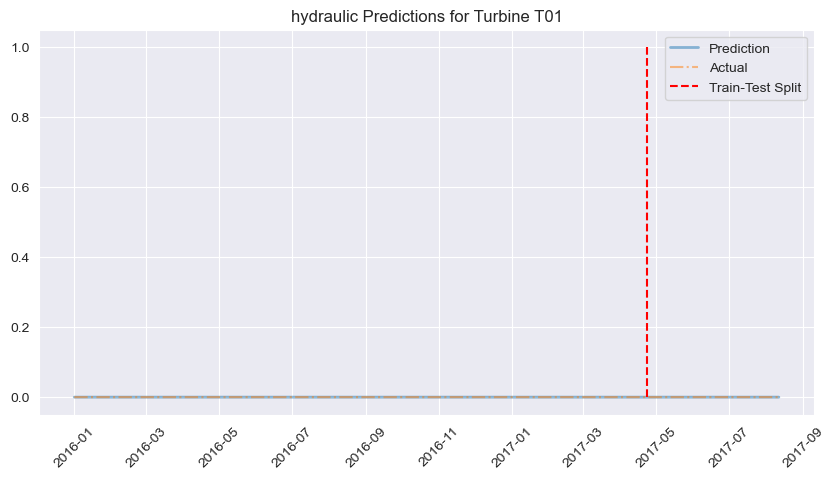

1 2 [] -42000


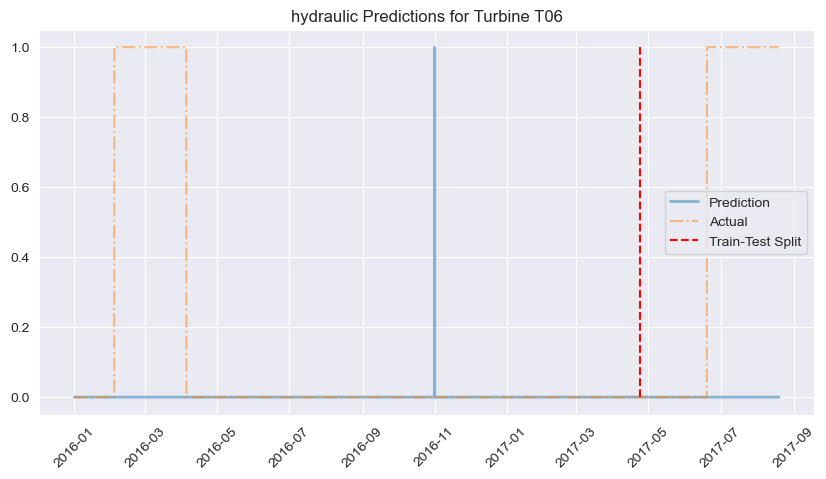

1 1 [] -22000


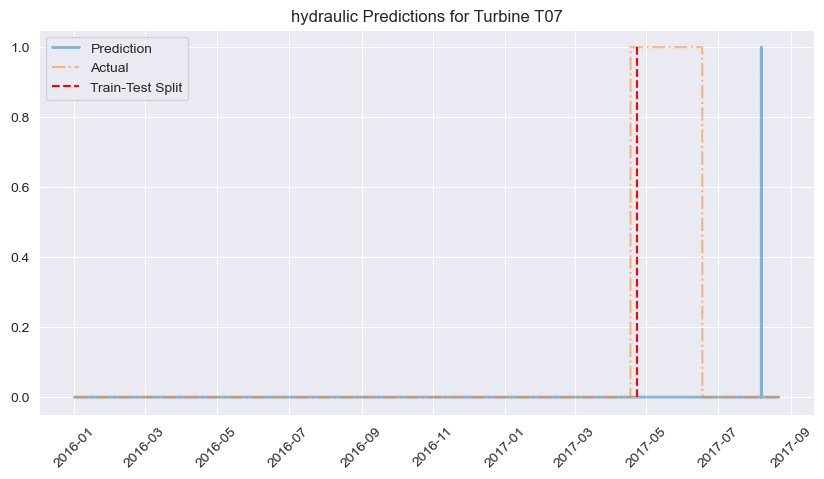

1 0 [] -2000


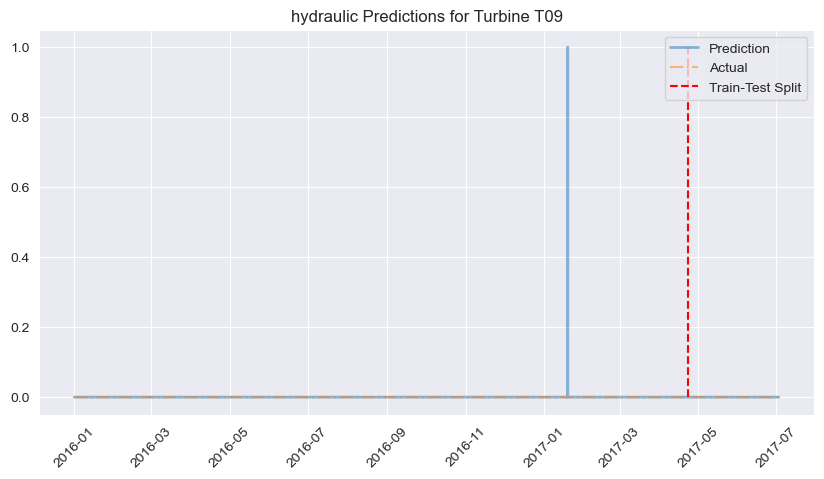

0 2 [] -40000


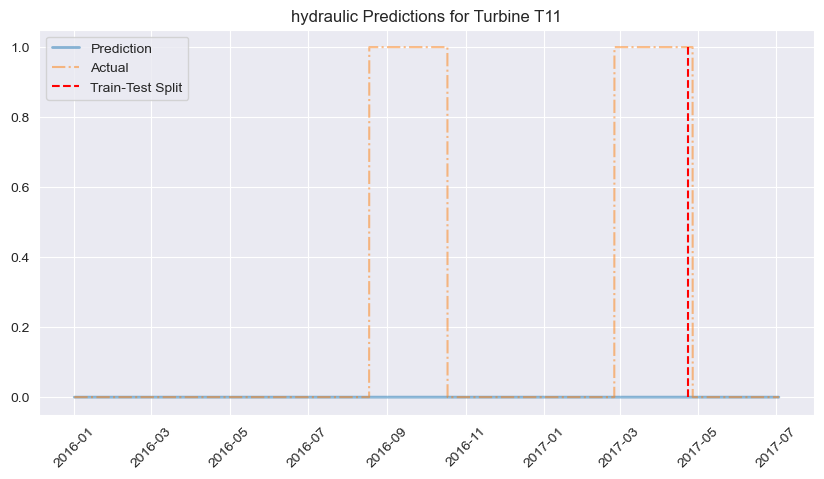

Total Savings: -106000


In [18]:
R, M, I = 20000, 3000, 2000
total_savings = 0
warn_issue = {}
for t in ['T01','T06','T07','T09','T11']:
    test_sub = all_signals_hourly[all_signals_hourly['Turbine_ID'] == t]
    y_true = test_sub.loc[:, 'Default_in_60_HYDRAULIC_GROUP'].to_numpy().astype(int)
    y_lead = test_sub.loc[:, 'Lead_Time_HYDRAULIC_GROUP'].to_numpy()
    event = test_sub['y_event'].to_numpy()
    X_test = test_sub[new_features]
    X_train_scaled, X_test_scaled = standard_scaler(X_train, X_test)
    y_pred = apply_isolation_forest(X_train_scaled, X_test_scaled)
    y_pred = (y_pred == -1).astype(int)
    time = test_sub['Timestamp'].to_numpy()
    
    consec_warn = 0
    consec_threshold = 24*3
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            consec_warn += 1
            if consec_warn < consec_threshold:
                y_pred[i] = 0
            elif consec_warn == consec_threshold:
                consec_warn = 0
        elif y_pred[i] == 0:
            if consec_warn > 0:
                consec_warn = 0

    last_warn_time = None
    for i in range(len(y_pred)):
        if y_pred[i] == 1 and last_warn_time is None:
            last_warn_time = time[i]
        elif y_pred[i] == 1 and last_warn_time is not None:
            warn_time = time[i]
            if (warn_time - last_warn_time) / np.timedelta64(1, 'D') < 7:
                y_pred[i] = 0
            else:
                last_warn_time = warn_time
    
    FP, FN, TP_lead, savings = get_savings(y_true, y_pred, event, y_lead, R, M, I)
    print(FP, FN, TP_lead, savings)
    total_savings += savings

    plt.figure(figsize=(10, 5))  # Optional: Define the size of the plot
    plt.plot(time, y_pred, linewidth=2, alpha=0.5, label="Prediction")
    plt.plot(time, y_true, ls="-.", alpha=0.5, label="Actual")
    plt.vlines(x=st, ymin=0, ymax=1, ls="--", label="Train-Test Split", color="red")
    plt.title(f"{'hydraulic'} Predictions for Turbine {t}")
    plt.legend(loc="best")
    plt.xticks(rotation=45)
    plt.show()
print(f"Total Savings: {total_savings}")